In [1]:
import os
import datetime
import copy
import torch
from torch.nn import Module
import tqdm
import numpy as np 
import gym
from gym import Env
from gym.spaces import Box
from gym .utils.env_checker import check_env
from typing import (
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [2]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

1.8.0
0.21.0



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [3]:
N = 100 # number of datapoints 
xvalues = np.linspace(-2, 2, N) # sequences from -3 to 3 with N values

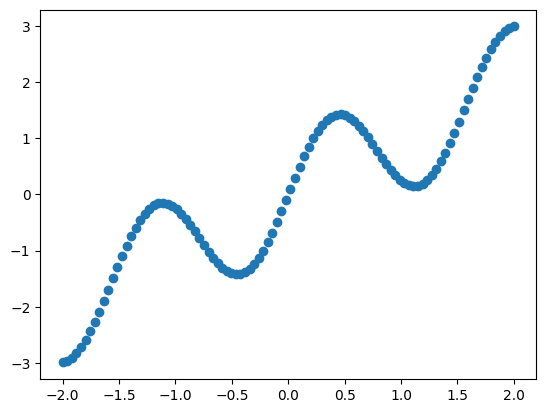

In [4]:
sine_wave = xvalues + np.sin(4*xvalues)
plt.plot(xvalues, sine_wave, 'o');

In [5]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

In [6]:
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(1, 24),
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 1
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 2
        torch.nn.ReLU(),
        torch.nn.Linear(24, 1)
    )

def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray,
               y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(model: torch.nn.Module,
                           opt: torch.optim,
                           X_train: torch.Tensor, 
                           y_train: torch.Tensor, 
                           X_test: torch.Tensor, 
                           y_test: torch.Tensor, 
                           n_epochs: int=500, 
                           batch_size: int=1,
                           show_progress: bool=True) -> Tuple[List[torch.Tensor], 
                                                              List[torch.Tensor], 
                                                              float, 
                                                              OrderedDict[str, torch.tensor]]:
    loss_fn = torch.nn.MSELoss()
    best_mse = np.inf
    best_weights = None
    loss_history = []
    prediction_history = []
    
    ##############
    # 500 epochs 
    ##############
    for epoch in range(n_epochs):
        # train model on batches (which here is just a singular value)
        model.train()
        ################
        # 100 samples 
        ################
        if show_progress:
            pbar = tqdm.tqdm(total=len(X_train))
            pbar.set_description(f"Epoch {epoch}")
        for batch_index in range(round(len(X_train)/batch_size)):
            ################
            # 1 sample at a time (batch size = 1)
            ################
            X_batch = X_train[batch_index : batch_index + batch_size]
            y_batch = y_train[batch_index : batch_index + batch_size]

            # forward pass
            y_pred = model(X_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # update weights via backprop
            opt.zero_grad()
            loss.backward()
            opt.step()

            if show_progress: pbar.update(10)
        if show_progress: pbar.close()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        loss_history.append(mse)
        prediction_history.append(y_pred)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
    
    return prediction_history, loss_history, best_mse, best_weights


def predict_from_composed_layers(layers):
    y_hats = []
    for x in np.linspace(-2,2,100):
        x = torch.Tensor([x])
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)
    return y_hats


# functions for to create above performance curve
def make_predictions(X: torch.Tensor, 
                     model: torch.nn.Module) -> List[torch.Tensor]:
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)


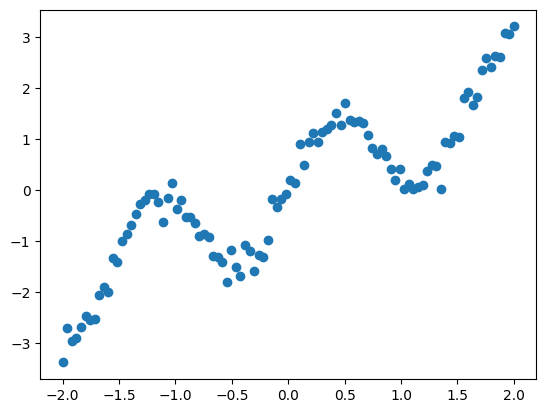

In [7]:
noisy_sine_wave = xvalues + np.sin(4*xvalues) + np.random.normal(0,0.2, 100)
plt.plot(xvalues, noisy_sine_wave, 'o');

In [8]:
x_for_split = xvalues.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [9]:
x_for_split.shape

(100, 1)

In [10]:
sine_wave.shape

(100,)

In [11]:
# depiction of how batch training works (i.e., that you just returned a 
# vector with as the same # of outputs and you passed inputs)
model = build_model()
print(X_train[0:5])
print(model(X_train[0:5]))
print()
print(X_train[0])
print(model(X_train[0]))

tensor([[-1.8384],
        [-1.2323],
        [ 0.6667],
        [ 1.8788],
        [-0.7071]])
tensor([[0.2011],
        [0.2072],
        [0.1937],
        [0.1545],
        [0.2118]], grad_fn=<AddmmBackward0>)

tensor([-1.8384])
tensor([0.2011], grad_fn=<AddBackward0>)


# Global training params

In [12]:
NUM_POOL_LAYERS=1000
MAX_TARGET_LAYERS=50
NUM_NODES=32
SEED=123
LOSS_FN=torch.nn.MSELoss()
EPOCHS=1000
MODEL=build_model()
OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
TIMESTEPS=20000

def reset_env(**kwargs):
    MODEL=build_model()
    OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)

def print_env():
    print(f'NUM_POOL_LAYERS  {NUM_POOL_LAYERS}')
    print(f'MAX_TARGET_LAYERS  {MAX_TARGET_LAYERS}')
    print(f'NUM_NODES  {NUM_NODES}')
    print(f'SEED  {SEED}')
    print(f'LOSS_FN  {LOSS_FN}')
    print(f'EPOCHS  {EPOCHS}')
    print(f'MODEL  {MODEL}')
    print(f'OPT  {OPT}')
    print(f'TIMESTEPS  {TIMESTEPS}')

print_env()

NUM_POOL_LAYERS  1000
MAX_TARGET_LAYERS  50
NUM_NODES  32
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000


# Train (normal data)

In [13]:
%%time
reset_env()
prediction_history, loss_history, best_mse, best_weights = train_regression_model(MODEL, 
                                                                                  OPT,
                                                                                  X_train, 
                                                                                  y_train, 
                                                                                  X_test, 
                                                                                  y_test, 
                                                                                  n_epochs=EPOCHS, 
                                                                                  batch_size=1, 
                                                                                  show_progress=False)

CPU times: user 2min 28s, sys: 225 ms, total: 2min 28s
Wall time: 1min 46s


In [14]:
# list of length n with tensor([30,1]), where n is the number of epochs we ran
print(type(prediction_history))
print(len(prediction_history))
prediction_history[0].shape

<class 'list'>
1000


torch.Size([30, 1])

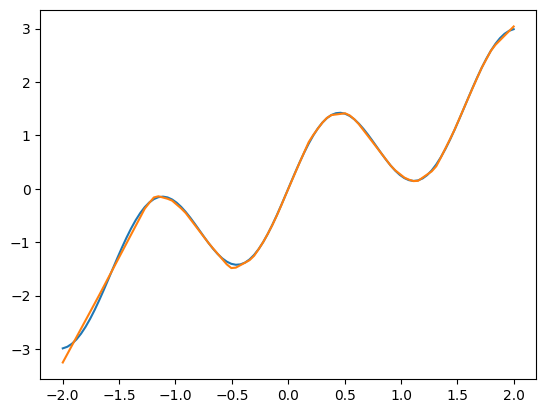

In [15]:
# print predicted values for each of the 100 x values between -2 and 2
# converting to tensor to run it through the model
# then converting it to numpy to plot it 
predictions = [MODEL(torch.tensor(sample).float()) for sample in xvalues.reshape((N,1))]
plt.plot(xvalues, xvalues + np.sin(4*xvalues))
plt.plot(xvalues, np.array([_.detach().numpy() for _ in predictions]));

In [16]:
# functions for to create above performance curve
def make_predictions(X: torch.Tensor, 
                     model: torch.nn.Module) -> List[torch.Tensor]:
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

MSE: 0.00
RMSE: 0.05


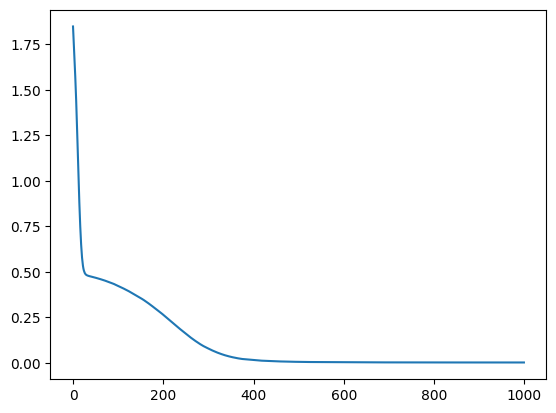

In [17]:
# visualize the mean squared error (mse)
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(loss_history)
plt.show()

# Train (noisy data)

In [18]:
reset_env()

In [21]:
%%time
nprediction_history, nloss_history, nbest_mse, nbest_weights = train_regression_model(MODEL, 
                                                                                      OPT,
                                                                                      noisy_X_train, 
                                                                                      noisy_y_train, 
                                                                                      noisy_X_test, 
                                                                                      noisy_y_test, 
                                                                                      n_epochs=1000, 
                                                                                      batch_size=1, 
                                                                                      show_progress=False)

CPU times: user 35.5 s, sys: 35.8 ms, total: 35.6 s
Wall time: 35.6 s


MSE: 0.06
RMSE: 0.25


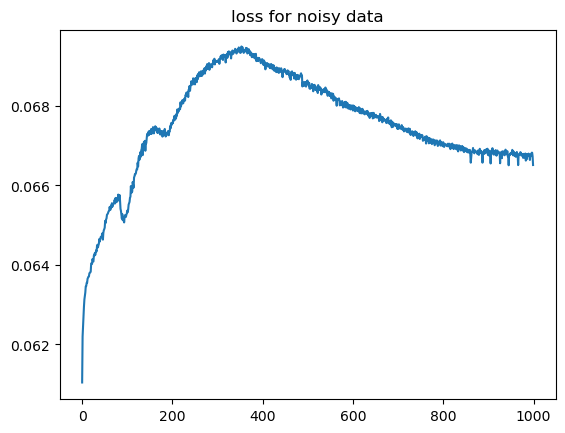

In [22]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.title("loss for noisy data")
plt.plot(nloss_history)
plt.show()

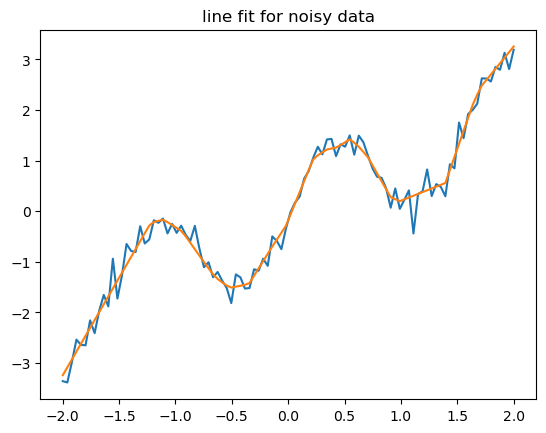

In [25]:
predictions = make_predictions(xvalues, MODEL)
plot_predictions_versus_ground(xvalues, noisy_sine_wave, predictions, plot_title="line fit for noisy data")

# Reinforcement Meta-Learning

3 classes
- layer pool
- target network -- composed of layers from layer pool
- meta learner -- decides which layers from layer pool to add to target network

So, (meta learner) -> (layer pool) -> (target network)

In [13]:
class LayerPool:
    '''
    Pool of NUM_POOL_LAYERS dense layers, each with NUM_NODES nodes to be 
    composed by the RL agent.
    '''
    def __init__(self, 
                 in_features: int,
                 out_features: int,
                 num_layers: int=NUM_POOL_LAYERS, 
                 num_nodes_per_layer: int=NUM_NODES):
        self.num_layers = num_layers
        self.num_nodes_per_layer = num_nodes_per_layer

        # these layers comprise the layer pool
        # each layer has a metadata object associated with it that stores useful information
        # each layer that is used gets updated (i.e., their parameters change and the copy in 
        # this layer pool is updated)
        self.layers = { 
                       id : Layer(layer) 
                       for id, layer in enumerate([torch.nn.Linear(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer) for _ in range(num_layers)])
                       }
        [torch.nn.init.xavier_uniform_(layer_meta_obj.layer.weight) for layer_meta_obj in self.layers.values()]

        # these 'initial' and 'final' layers are the first layers in each target network
        # they are also uniquely updated for each target network (i.e., they aren't included in the self.layers pool
        # for other future target networks to have access to)
        # we don't have meta objects for these layers because they are used by every target network
        self.initial_layer = torch.nn.Linear(in_features, NUM_NODES)
        self.final_layer = torch.nn.Linear(NUM_NODES, out_features)
        torch.nn.init.xavier_uniform_(self.final_layer.weight)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)


class Layer:
    '''
    Metadata object to hold layer and track some useful information about the layer.
    '''
    def __init__(self, 
                 layer: torch.nn.Linear):
        self.layer = layer
        self.used = False
        self.times_used = 0

In [14]:
MAX_TARGET_LAYERS=10
TIMESTEPS=5000

In [43]:
class TargetNetwork(gym.Env, Module):
    '''
    This is the 'target' model that is constructed for the task.
    
    step() returns the next state (the next layer) and reward (the negative loss)
    reset() returns an initial state and the info dict

    TODO
    [] consider adding +1 to self.action_space for the action that is to NOT compose another layer
    [] ensure that metarl can't choose the initial or final layer (i.e., these are not part of action space)
    '''
    def __init__(self, 
                 X: np.ndarray,
                 y: np.ndarray,
                 layer_pool: LayerPool,
                 max_target_layers: int,
                 num_nodes_per_layer: int):

        super(TargetNetwork, self).__init__()
        self.observation_space = Box(low=float('-inf'), high=float('inf'), shape=(num_nodes_per_layer,)) # vector with latent space of network
        self.action_space = Box(low=0., high=1., shape=(NUM_POOL_LAYERS,)) # vector of probabilities for each layer in pool

        # data 
        self.X = X
        self.y = y
        self.curr_i = 0
        self.curr_x = torch.Tensor( [X[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.curr_y = torch.Tensor( [y[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.layer_pool = layer_pool

        # nn module
        # https://discuss.pytorch.org/t/how-to-add-a-layer-to-an-existing-neural-network/30129/3
        self.max_target_layers = max_target_layers
        self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer]) # every target network begins with the same initial and final layers
        self.state = self.reset() 
        self.layerpool_indices = [] # doesn't include the indices of 'initial' and 'final' layers because they don't exist
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=0.001)


    def run_inner_loop(self) -> Tuple[np.ndarray, float]: 
        '''
        Performs inferences using "inner loop" network that we are composing. Returns next state and its reward.

        NOTE Design choice whether to train with new layer first. Currently training first.
        '''
        self.train()
        self.curr_i  = (self.curr_i + 1) % len(self.X) # go through data multiple times / dataset does not dictate truncation condition
        self.curr_x = torch.Tensor( [self.X[self.curr_i]] ) 
        self.curr_y = torch.Tensor( [self.y[self.curr_i]] )

        def predict(x):
            for i in range(len(self.fcs) - 1): # -1 because we don't want the last output layer yet
                x = torch.nn.functional.relu(self.fcs[i](x))
            s_prime = x
            y_hat = self.fcs[-1](x)
        
            return self.loss_fn(self.curr_y, y_hat), s_prime, self.loss_fn(self.curr_y, y_hat)

        # update params
        loss, s_prime, reward = predict(self.curr_x)
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=0.001) # re-create because parameters added
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # push updated params to pool
        for i in range(len(self.layerpool_indices)):
            pool_index = self.layerpool_indices[i]
            updated_layer_copy = self.fcs[i]
            self.layer_pool.layers[pool_index].layer = updated_layer_copy
            self.layer_pool.layers[pool_index].used = True
            self.layer_pool.layers[pool_index].times_used += 1
        
        _, s_prime, reward = predict(self.curr_x)

        return s_prime.detach().numpy().T.squeeze(), float(reward.detach().numpy())

    def reset(self) -> np.ndarray:
        '''
        Returns initial state (as the same type 'observation_space' is) and any 
        additional info (as a dict, the same as returned by step).
        '''
        print("[INFO] Reset env.")

        # BUG  Stabebaselines3 seems to call the reset() method even when we're not terminating.
        # self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer])

        initial_x = torch.Tensor( [self.X[0]] )
        initial_state = torch.nn.functional.relu(self.fcs[0](initial_x))

        return initial_state.detach().numpy().T.squeeze() # TODO(ms): is there a better way to massage this data?
    
    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, int, bool, dict]: # "given some new layer"
        # action is probability for each layer in pool
        if len(self.fcs) < MAX_TARGET_LAYERS:
            pool_index = np.argmax(action)
            self.layerpool_indices.append(pool_index) # now I know what layer in pool I am composing

            # compose layer to model and get s' and r from the model
            next_layer = self.layer_pool.layers[pool_index].layer

            final_layer = self.fcs.pop(-1)
            self.fcs.append(next_layer)  # compose new layer 
            self.fcs.append(final_layer) # re-insert final layer
        s_prime, reward = self.run_inner_loop()

        # temporary terminate logic
        done = False # TODO(ms): update to make episodic? is this continuous learning?

        return (
            s_prime,
            reward, 
            done, 
            {}
        )
    
    def render(self, mode='human', close=False):
        print(f'[INFO] # of layers {len(self.fcs)}')

    def close(self):
        pass

## Experiment: getting the stablebaselines environment to work

In [44]:
print_env()

NUM_POOL_LAYERS  1000
MAX_TARGET_LAYERS  10
NUM_NODES  32
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  5000


In [45]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

# create (1) LayerPool, (2) TargetNetwork, (3) Metarl instances
layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
env = TargetNetwork(
    X, 
    y, 
    layer_pool, 
    max_target_layers=MAX_TARGET_LAYERS,
    num_nodes_per_layer=NUM_NODES,
    )
stable_baselines3.common.env_checker.check_env(env)

# wrap gym env

metarl = A2C('MlpPolicy', env)
metarl.learn(total_timesteps=TIMESTEPS)          

[INFO] Reset env.
[INFO] Reset env.
[INFO] Reset env.


/home/matt/miniconda3/envs/masters-thesis/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:384: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


CPU times: user 22.1 s, sys: 351 ms, total: 22.4 s
Wall time: 22.4 s


In [ ]:
# performance
y_hats = []
for x in np.linspace(-2,2,100):
    x = torch.Tensor([x])
    for i in range(len(env.fcs)-1):
        x = torch.nn.functional.relu(env.fcs[i](x))
    x = env.fcs[-1](x) # do not relu the very last calculation
    y_hats.append(x)
print(y_hats)

[tensor([-1.7303], grad_fn=<AddBackward0>), tensor([-1.6920], grad_fn=<AddBackward0>), tensor([-1.6537], grad_fn=<AddBackward0>), tensor([-1.6154], grad_fn=<AddBackward0>), tensor([-1.5771], grad_fn=<AddBackward0>), tensor([-1.5389], grad_fn=<AddBackward0>), tensor([-1.5006], grad_fn=<AddBackward0>), tensor([-1.4623], grad_fn=<AddBackward0>), tensor([-1.4242], grad_fn=<AddBackward0>), tensor([-1.3862], grad_fn=<AddBackward0>), tensor([-1.3481], grad_fn=<AddBackward0>), tensor([-1.3100], grad_fn=<AddBackward0>), tensor([-1.2720], grad_fn=<AddBackward0>), tensor([-1.2339], grad_fn=<AddBackward0>), tensor([-1.1958], grad_fn=<AddBackward0>), tensor([-1.1580], grad_fn=<AddBackward0>), tensor([-1.1263], grad_fn=<AddBackward0>), tensor([-1.1137], grad_fn=<AddBackward0>), tensor([-1.1160], grad_fn=<AddBackward0>), tensor([-1.1289], grad_fn=<AddBackward0>), tensor([-1.1450], grad_fn=<AddBackward0>), tensor([-1.1606], grad_fn=<AddBackward0>), tensor([-1.1814], grad_fn=<AddBackward0>), tensor([-1

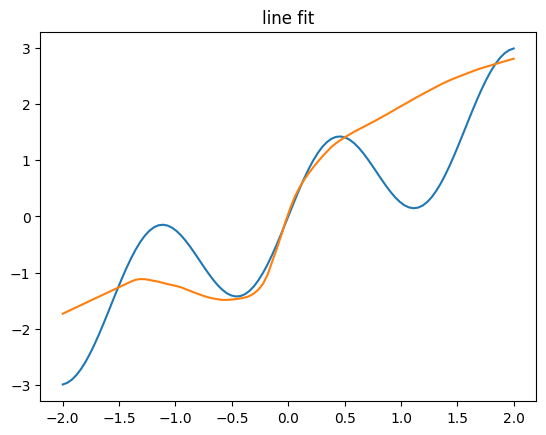

In [20]:
plot_predictions_versus_ground(np.linspace(-2,2,100), sine_wave, y_hats)

## Experiment: increasing # of layers

More layers don't help (this simple example). They do hurt performance somewhat, but after a certain depth, it becomes random and a network with thousands more layers can perform better than a network with thousands more layers less.

In [54]:
def predict_from_composed_layers(layers):
    y_hats = []
    for x in np.linspace(-2,2,100):
        x = torch.Tensor([x])
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)
    return y_hats

### 5 -> 50 depth networks (5 step size)

In [57]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(5, 50, 5):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 5:  [tensor([-2.6857], grad_fn=<AddBackward0>), tensor([-2.6110], grad_fn=<AddBackward0>), tensor([-2.5245], grad_fn=<AddBackward0>), tensor([-2.4118], grad_fn=<AddBackward0>), tensor([-2.2911], grad_fn=<AddBackward0>), tensor([-2.1597], grad_fn=<AddBackward0>), tensor([-2.0256], grad_fn=<AddBackward0>), tensor([-1.8915], grad_fn=<AddBackward0>), tensor([-1.7573], grad_fn=<AddBackward0>), tensor([-1.6232], grad_fn=<AddBackward0>), tensor([-1.4891], grad_fn=<AddBackward0>), tensor([-1.3549], grad_fn=<AddBackward0>), tensor([-1.2325], grad_fn=<AddBackward0>), tensor([-1.1305], grad_fn=<AddBackward0>), tensor([-1.0286], grad_fn=<AddBackward0>), tensor([-0.9266], grad_fn=<AddBackward0>), tensor([-0.8247], grad_fn=<AddBackward0>), tensor([-0.7227], grad_fn=<AddBackward0>), tensor([-0.6208], grad_fn=<AddBackward0>), tensor([-0.5225], grad_fn=<AddBackward0>), tensor([-0.4332], grad_fn=<AddBackward0>), tensor([-0.3488], grad_fn=<AddBackward0>), tensor([-0.2825], grad_fn=<AddBackward0>), 

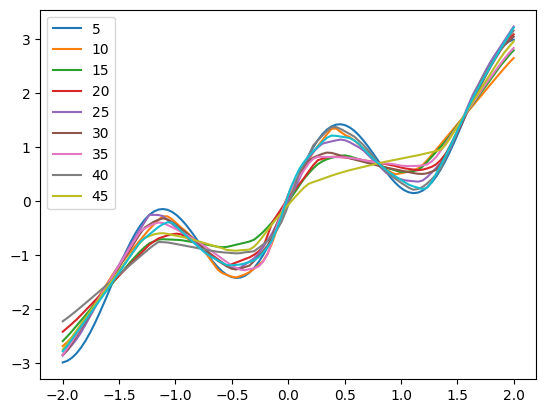

In [63]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

In [64]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 100, 10):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.9578], grad_fn=<AddBackward0>), tensor([-2.8413], grad_fn=<AddBackward0>), tensor([-2.7201], grad_fn=<AddBackward0>), tensor([-2.5898], grad_fn=<AddBackward0>), tensor([-2.4468], grad_fn=<AddBackward0>), tensor([-2.2985], grad_fn=<AddBackward0>), tensor([-2.1501], grad_fn=<AddBackward0>), tensor([-2.0018], grad_fn=<AddBackward0>), tensor([-1.8535], grad_fn=<AddBackward0>), tensor([-1.7052], grad_fn=<AddBackward0>), tensor([-1.5538], grad_fn=<AddBackward0>), tensor([-1.3997], grad_fn=<AddBackward0>), tensor([-1.2456], grad_fn=<AddBackward0>), tensor([-1.1174], grad_fn=<AddBackward0>), tensor([-1.0031], grad_fn=<AddBackward0>), tensor([-0.8888], grad_fn=<AddBackward0>), tensor([-0.7745], grad_fn=<AddBackward0>), tensor([-0.6663], grad_fn=<AddBackward0>), tensor([-0.5694], grad_fn=<AddBackward0>), tensor([-0.4955], grad_fn=<AddBackward0>), tensor([-0.4298], grad_fn=<AddBackward0>), tensor([-0.4184], grad_fn=<AddBackward0>), tensor([-0.4353], grad_fn=<AddBackward0>),

### 10 -> 100 depth networks (10 step size)

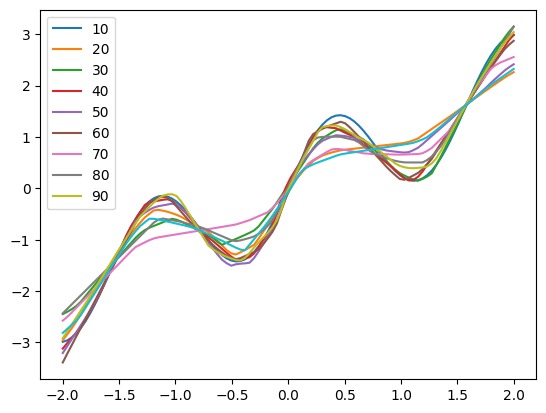

In [66]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

### 10 -> 1010 depth networks (1000 step size)

In [67]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 10010, 1000):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.6770], grad_fn=<AddBackward0>), tensor([-2.5701], grad_fn=<AddBackward0>), tensor([-2.4563], grad_fn=<AddBackward0>), tensor([-2.3424], grad_fn=<AddBackward0>), tensor([-2.2285], grad_fn=<AddBackward0>), tensor([-2.1142], grad_fn=<AddBackward0>), tensor([-1.9919], grad_fn=<AddBackward0>), tensor([-1.8697], grad_fn=<AddBackward0>), tensor([-1.7474], grad_fn=<AddBackward0>), tensor([-1.6242], grad_fn=<AddBackward0>), tensor([-1.5009], grad_fn=<AddBackward0>), tensor([-1.3776], grad_fn=<AddBackward0>), tensor([-1.2544], grad_fn=<AddBackward0>), tensor([-1.1311], grad_fn=<AddBackward0>), tensor([-1.0078], grad_fn=<AddBackward0>), tensor([-0.8845], grad_fn=<AddBackward0>), tensor([-0.7615], grad_fn=<AddBackward0>), tensor([-0.6402], grad_fn=<AddBackward0>), tensor([-0.5265], grad_fn=<AddBackward0>), tensor([-0.4165], grad_fn=<AddBackward0>), tensor([-0.3581], grad_fn=<AddBackward0>), tensor([-0.3035], grad_fn=<AddBackward0>), tensor([-0.2515], grad_fn=<AddBackward0>),

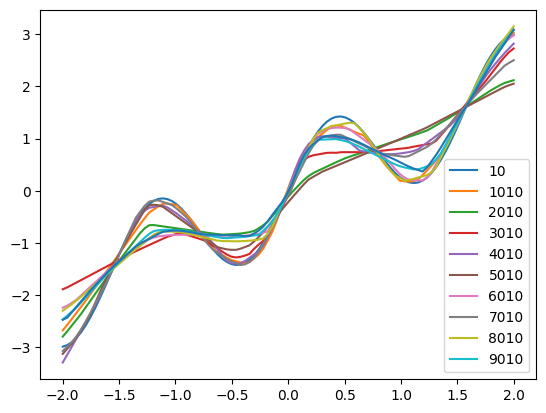

In [68]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

## Experiment: learning from multiple tasks (8)

- 8 tasks are 8 slightly different sine curves to create models for 
- only varying amplitude of sine curve
- same layer pool for all 8 runs
- same outer-loop (metarl) for all 8 runs
- different inner-loop (target network) for all 8 runs
- investigating
    - degree to which trained layers are used

In [24]:
NUM_TASKS=8
tasks = {
    str(round(f))+str("_task") : (xvalues/round(f)) + np.sin(4*xvalues) + np.random.normal(0, 0.2, 100)
    for f in np.linspace(1, 1000, NUM_TASKS)

}
print(tasks.keys())

dict_keys(['1_task', '144_task', '286_task', '429_task', '572_task', '715_task', '857_task', '1000_task'])


In [25]:
TIMESTEPS=5000

In [26]:
MAX_TARGET_LAYERS=10

In [27]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
task_to_yhats = {}
for i, (n, curve) in enumerate(tasks.items()):
    print(f'[INFO] Training {i+1}/{NUM_TASKS}.')
    env = TargetNetwork(
        X, 
        curve, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    if i==0: # create new rl agent
        metarl = A2C('MlpPolicy', env)
    else:    # just update the env
        metarl.set_env(env)
        print(f'[INFO] Updated environment to {env.y}')

    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    task_to_yhats[n] = y_hats

[INFO] Training 1/8.
[INFO] Reset env.
[INFO] Reset env.
2
3
4
5
6
7
8
9
[INFO] Training 2/8.
[INFO] Reset env.
[INFO] Updated environment to [-0.99447197 -1.29910899 -0.99076435 -0.75429812 -1.29002883 -0.97481509
 -0.62789814 -0.52906368 -0.64616492 -0.40538121 -0.36269041  0.38167291
  0.29321562  0.27008738  0.65982001  0.4695958   0.74314108  1.04102264
  1.14109715  0.82410036  0.89898112  0.42544061  0.97006911  0.95055851
  0.70804372  0.47473673  0.32482327  0.29720994  0.35526015 -0.10352365
 -0.17539907  0.038917   -0.59757326 -0.62049728 -0.32841067 -0.72965203
 -0.87736735 -0.75365524 -1.24893129 -0.67126164 -1.07463582 -1.04778828
 -0.54482081 -0.72641579 -0.77365855 -0.58589835 -0.56444814 -0.29827966
 -0.33598337 -0.04942334  0.00203697  0.49317191  0.56039327  0.66453415
  0.33300176  0.48881595  0.81179349  1.0858216   0.95701322  1.04251656
  1.12591685  1.25613802  0.70802098  1.00414549  0.71669025  0.80953874
  0.29470693  0.29780098 -0.20249567  0.3137126  -0.551

KeyboardInterrupt: 

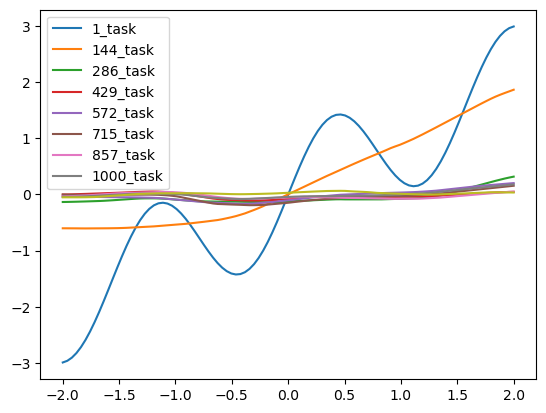

In [ ]:
'''
Decreasing max layers helps. At 1000 (rather than 5), the lines are flat. Nothing is learned.
Increasing timesteps helps. More steps.
'''
TIMESTEPS=1000
MAX_TARGET_LAYERS=5
plt.plot(X, y)
for y_hats in task_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in task_to_yhats.keys()]);

In [ ]:
TIMESTEPS=30000
MAX_TARGET_LAYERS=5
layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
task_to_yhats = {}
for i, (n, curve) in enumerate(tasks.items()):
    print(f'[INFO] Training {i+1}/{NUM_TASKS}.')
    env = TargetNetwork(
        X, 
        curve, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    if i==0: # create new rl agent
        metarl = A2C('MlpPolicy', env)
    else:    # just update the env
        metarl.set_env(env)
        print(f'[INFO] Updated environment to {env.y}')

    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    task_to_yhats[n] = y_hats

[INFO] Training 1/8.
[INFO] Training 2/8.
[INFO] Updated environment to [-0.82362782 -1.08704724 -0.96305202 -1.18899946 -0.91734876 -0.76668388
 -0.43577197 -0.60412609 -0.50579267 -0.30293724 -0.11176766  0.16759404
  0.43085266  0.46108166  0.41111722  0.73103953  0.59737246  0.96043411
  0.8375236   0.82933388  0.97825867  0.73650278  0.95588938  0.51349601
  0.82635639  0.70333004  0.464231    0.44769892  0.46615842 -0.25714709
 -0.08921493 -0.16247944 -0.2700227  -0.29320805 -0.70752293 -1.17091789
 -1.0201006  -1.31385189 -0.93812108 -1.15047056 -1.15726049 -1.18249065
 -0.76322589 -1.06426827 -0.75503417 -0.81147257 -0.57918091 -0.64867848
 -0.28172316  0.2165158  -0.10536994 -0.05849649  0.3177476   0.62313214
  0.86600087  0.9315234   0.79681896  0.72168653  1.58736253  1.04000382
  1.09984033  0.68318393  0.79673796  0.60285719  0.56836718  0.4776959
  0.61036434  0.33731578  0.23806247  0.01709905 -0.59422207  0.09638116
 -0.72900261 -0.5614937  -1.02373323 -0.91326821 -0.8

In [ ]:
# increased timesteps from 10000 to 30000
plt.plot(X, y)
for y_hats in task_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in task_to_yhats.keys()]);

NameError: name 'X' is not defined

In [ ]:
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1

NameError: name 'plt' is not defined

In [ ]:
# test how many layers are reused
# so needs to mark layers are 'visited'
# metrics can be (1) % of layers that were already used, (2) speed of training 